In [1]:
%reload_ext tensorboard
%reload_ext autoreload

# Normalising Soft Ambient Flows

In [2]:
import os
import time
import math
import torch
import numpy as np
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.distributions as tdist
import torchdyn.nn.node_layers as tdnl

from joblib import dump, load
from sklearn.decomposition import PCA
from pdmtut.core import GenerativeModel
from pytorch_lightning import loggers as pl_loggers
from regilib.core.distributions import MultivariateNormal
from regilib.core.dynamics.dynamics import RegularisedDynamics
from regilib.core.dynamics.dynamical_state import DynamicalState
from regilib.core.invertible_modules import NormalisingFlow
from regilib.core.invertible_modules.bijective import ContinuousAmbientFlow

In [3]:
store_results = True
load_models = True

## Introduction

## Implementation

In [4]:
class NormalisingSoftAmbientFlows(NormalisingFlow, pl.LightningModule, GenerativeModel):
    class FunctionDynamics(nn.Module):
        def __init__(self):
            super().__init__()
            
            self._in_channels = 3
            self._out_channels = 3
            
            # expected format: N x (C * L)
             # +1 for time, + 1 for noise condition
            self.fc1 = nn.Linear(self._in_channels + 2, 64)
            self.fc2 = nn.Linear(64, 128)
            self.fc3 = nn.Linear(128, 128)
            self.fc4 = nn.Linear(128, 64)
            self.fc5 = nn.Linear(64, self._out_channels)  
            
        @property
        def in_channels(self):
            return self._in_channels

        @property
        def out_channels(self):
            return self._out_channels

        def forward(self, ds):
            x = torch.cat([ds.state, ds.condition, ds.t], -1)
            x = F.tanh(self.fc1(x))
            x = F.tanh(self.fc2(x))
            x = F.tanh(self.fc3(x))
            x = F.tanh(self.fc4(x))
            x = self.fc5(x)
            return x
    
    def __init__(self, input_dimensions = 3):
        super().__init__(
            base_distribution=MultivariateNormal(torch.zeros(3), torch.eye(3)))
        
        # [a,b] interval of standard deviation of noise distribution
        self.a, self.b = 0, 0.1
        
        self.input_dimensions = input_dimensions
        
        # state=[l, e, n | state]
        self.aug1 = tdnl.Augmenter(augment_dims=3)
        self.af1 = ContinuousAmbientFlow(
            dynamics=RegularisedDynamics(fdyn=NormalisingSoftAmbientFlows.FunctionDynamics()),
            sensitivity='autograd', default_n_steps=5
        )
        
    def noise_enhance_data(self, x, c=None, seed=None, perturb_state=True):
        ds = x.clone() if isinstance(x, DynamicalState) else DynamicalState(state=x)

        n_samples, device = ds.state.shape[0], ds.state.device
        
        # sample uniform distribution c ∈ [a, b]
        if c is None:
            if seed is not None: torch.manual_seed(seed)
            c = torch.FloatTensor(n_samples).uniform_(self.a, self.b)[:,None].to(device)
        else:
            c = c*torch.ones(n_samples, 1)

        if perturb_state: 
            # sample gaussian noise ν ∈ 𝓝(0, I*c)
            if seed is not None: torch.manual_seed(seed)
            nu = torch.randn(n_samples, 3, device=device) * c
            
            ds.state = ds.state + nu # perturb datapoint

        # scale c so that it matches [-1,+1] interval of points
        scale_c = 2*((c - self.a) / (1.e-10 + (self.b - self.a))) - 1
        ds.condition = scale_c # store std as condition
        
        return ds
 
    # Region NormalisingFlow
    def forward(self, ds, af_estimate=True):
        assert hasattr(ds, 'condition')
        
        ds = super().forward(ds)
        ds = self.af1.dynamics.update_ds(ds, self.aug1(ds['state']))
        ds = self.af1.forward(ds, estimate_trace=af_estimate)
        return ds

    def inverse(self, ds, af_estimate=True):
        assert hasattr(ds, 'condition')
        
        ds = self.af1.dynamics.update_ds(ds, self.aug1(ds['state']))
        ds = self.af1.inverse(ds, estimate_trace=af_estimate)
        ds = super().inverse(ds)
        return ds
    
    # Region GenerativeModel
    def encode(self, X, c, seed=None):
        if not isinstance(c, torch.Tensor):
            c = torch.tensor([c], dtype=torch.float)
        
        ds = DynamicalState(state=X)
        ds = self.noise_enhance_data(ds, c=c, seed=seed)
        ds = self.inverse(ds)
        return ds['state'].cpu().detach()

    def decode(self, z, c, seed=None):
        if not isinstance(c, torch.Tensor):
            c = torch.tensor([c], dtype=torch.float)
            
        ds = DynamicalState(state=z)
        
        # do not add noise to the latent state, this can lead to problems during reconstruction
        ds = self.noise_enhance_data(ds, c=c, seed=seed, perturb_state=False)
        ds = self.forward(ds)
        return ds['state'].cpu().detach()
    
    def save(self, path):
        torch.save(self, os.path.join(path, 'model.pt'))
    
    def load(path):
        return torch.load(os.path.join(path, 'model.pt'))
            
    def save_exists(path):
        return (
            os.path.isfile(os.path.join(path, 'model.pt')))

    def log_likelihood(self, x, c, seed=None):
        if not isinstance(c, torch.Tensor):
            c = torch.tensor([c], dtype=torch.float)
            
        ds = DynamicalState(state=x)
        ds = self.noise_enhance_data(ds, c=c, seed=seed)
        ds = self.inverse(ds, af_estimate=False)
        return ds.log_prob.cpu().detach()

    def sample_posterior(self, n_samples, c, seed=None):        
        z = self.sample_prior(n_samples)
        return self.decode(z, c, seed)
    
    def fit_model(self, X, X_val=None, path=None):
        start_time = time.time()
        
        if path is None:
            tb_logger = False
            checkpoint_callback=False
        else:
            tb_logger = pl_loggers.TensorBoardLogger(path, version=0)
            checkpoint_callback=True
        
        trainer = pl.Trainer(
            max_epochs=5000, gpus=1, logger=tb_logger,
            checkpoint_callback=checkpoint_callback
        )
        trainer.fit(
            self, train_dataloaders=X, val_dataloaders=X_val)
        elapsed_time = time.time() - start_time
        
        if path is not None: 
            with open(os.path.join(path, 'training_time.txt'), 'w') as f:
                f.write(str(elapsed_time))

    def training_step(self, batch, batch_idx):
        x = batch[0]
        lambda_e, lambda_n = 0.01, 0.01
        
        # state=[x+nu|c]
        ds_x_prime = self.noise_enhance_data(x)
        
        # logp(z_t1) = logp(z_t0) - \int_0^1 - Tr ∂f/∂z(t)
        ds_z = self.inverse(ds_x_prime, af_estimate=True)

        # minimise negative log likelihood and energy
        loss = (-ds_z.log_prob + lambda_e * ds_z.e[:, 0] + lambda_n * ds_z.n[:, 0]
        ).sum() / (x.shape[0]*x.shape[1])

        self.log('train_loss', loss)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        lambda_e, lambda_n = 0.01, 0.01
        
        # state=[x+nu|c]
        ds_x_prime = self.noise_enhance_data(x)
        
        # logp(z_t1) = logp(z_t0) - \int_0^1 - Tr ∂f/∂z(t)
        ds_z = self.inverse(ds_x_prime, af_estimate=True)

        loss = (-ds_z.log_prob + lambda_e * ds_z.e[:, 0] + lambda_n * ds_z.n[:, 0]).sum(
        ) / (x.shape[0]*x.shape[1])

        self.log('validation_loss', loss)
        return {'val_loss': loss}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return {
            'optimizer': optimizer,
            'lr_scheduler':
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, min_lr=1e-8, factor=0.5, verbose=True,
                patience=100
            ), 'monitor': 'train_loss'
        }

    def __str__(self):
        return 'snf'


## Experiment 1: swiss roll

In [5]:
import pyvista as pv
from pdmtut.datasets import SwissRoll

In [6]:
pv.set_plot_theme("document")

model_save_path = '../results/swiss_roll/snf'

if store_results:
    result_save_path = '../results/swiss_roll/snf'
    pv.set_jupyter_backend('None')
else:
    pv.set_jupyter_backend('ipygany')
    result_save_path = None

In [7]:
dataset = SwissRoll(n_samples=100**2, seed=11)

if load_models and NormalisingSoftAmbientFlows.save_exists(model_save_path):
    model = NormalisingSoftAmbientFlows.load(model_save_path)
else:
    model = NormalisingSoftAmbientFlows()
    model.fit_model(
        X=dataset.train_loader(batch_size=512),
        X_val=dataset.validation_loader(batch_size=512),
        path=result_save_path)
    
    if store_results:
        model.save(model_save_path)
        
model = model.eval()

In [8]:
%tensorboard --logdir ../results/swiss_roll/snf

### Input Representation

In [9]:
from pdmtut.vis import plot_representation

In [10]:
z = model.encode(dataset.X, c=0., seed=3)
z_extremes = model.encode(dataset.y_extremes, c=0., seed=3)

/home/bawaw/.conda/envs/pdm_tutorial_2/lib/python3.8/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


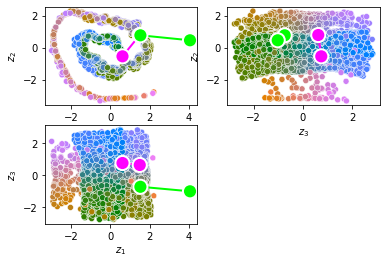

In [11]:
plot_representation(z.numpy(), index_colors=dataset.index_colors, z_extremes=z_extremes, interpolate_background=True, root=result_save_path)

### Input Reconstruction

In [12]:
from pdmtut.vis import plot_reconstruction

In [13]:
z = model.encode(dataset.X, c=0., seed=3)
x = model.decode(z, c=0., seed=3)

/home/bawaw/.conda/envs/pdm_tutorial_2/lib/python3.8/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


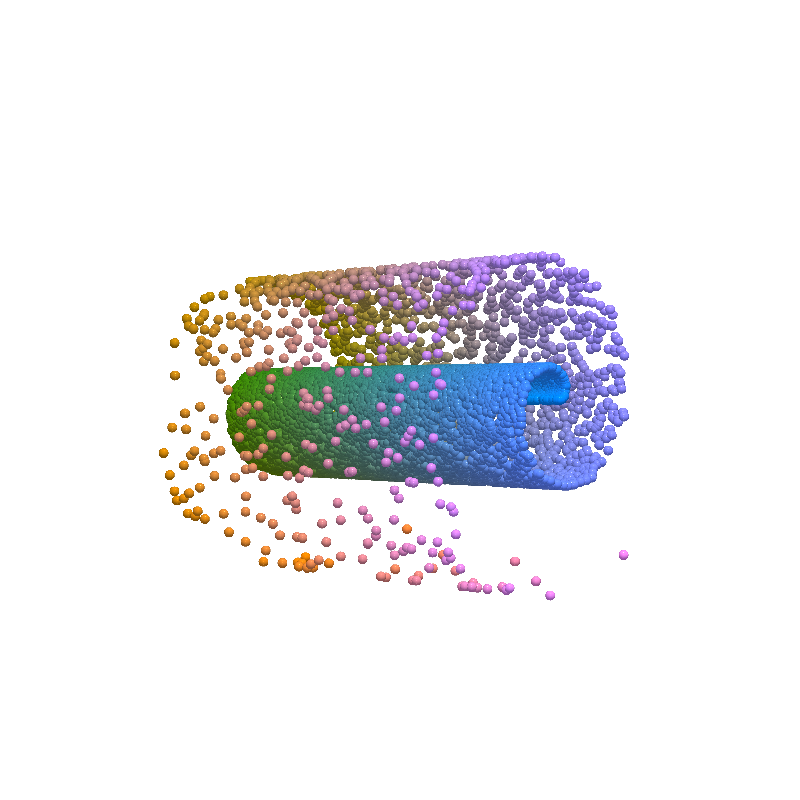

In [14]:
plot_reconstruction(dataset.unnormalise_scale(x).numpy(), dataset.index_colors, root=result_save_path)

### Density Estimation

In [15]:
from pdmtut.vis import plot_density

In [16]:
log_likelihood = model.log_likelihood(dataset.X, c=0., seed=3)

/home/bawaw/.conda/envs/pdm_tutorial_2/lib/python3.8/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


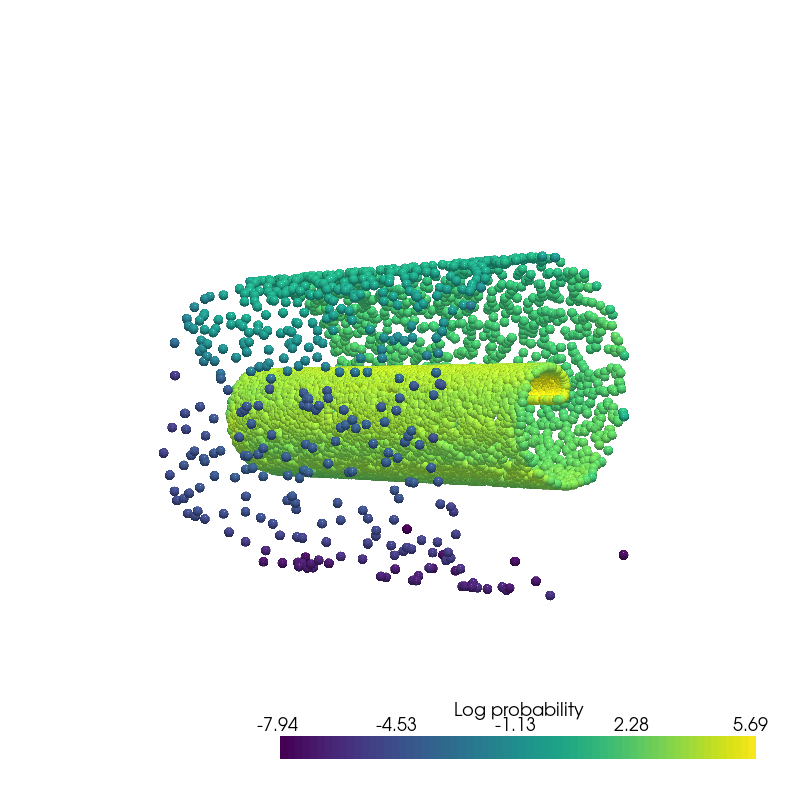

In [17]:
plot_density(dataset.unnormalise_scale(dataset.X).numpy(), log_likelihood.numpy(), root=result_save_path)

### Generate Samples

In [18]:
from pdmtut.vis import plot_generated_samples

In [19]:
generated_samples = model.sample_posterior(100**2, c=0., seed=3)
generated_samples_log_likelihood = model.log_likelihood(generated_samples, c=0., seed=3)

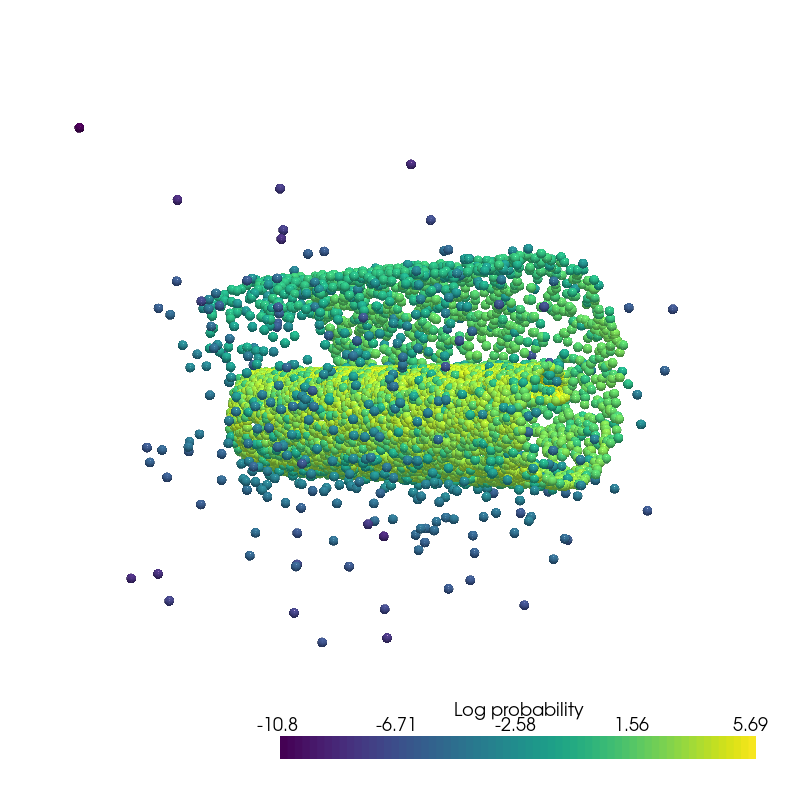

In [20]:
plot_generated_samples(dataset.unnormalise_scale(generated_samples).numpy(), generated_samples_log_likelihood.numpy(), root=result_save_path)

### Interpolation

In [21]:
from pdmtut.vis import plot_interpolation
from scipy.interpolate import interp1d

In [22]:
z_extremes = model.encode(dataset.y_extremes, c=0., seed=3)
uniform_state, uniform_log_prob, _ = dataset.sample_points_uniformly(n_samples=100**2, seed=11)

linfit1 = interp1d([1,20], z_extremes[:2].numpy(), axis=0)
linfit2 = interp1d([1,20], z_extremes[2:].numpy(), axis=0)

interpolated_points_1 = model.decode(torch.Tensor(linfit1(np.arange(1,21))), c=0., seed=3)
interpolated_points_2 = model.decode(torch.Tensor(linfit2(np.arange(1,21))), c=0., seed=3)

/home/bawaw/.conda/envs/pdm_tutorial_2/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


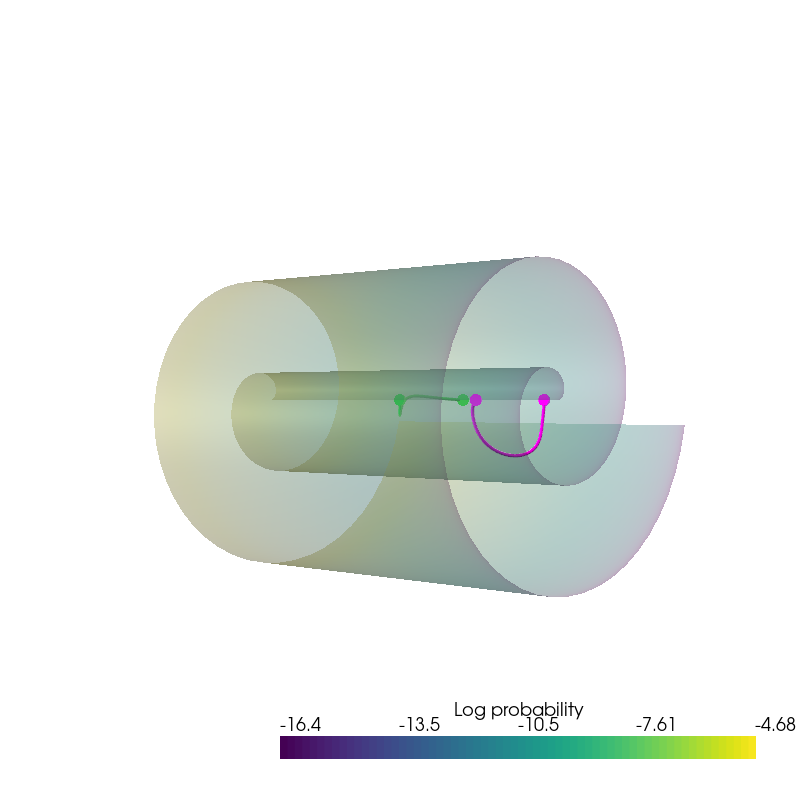

In [23]:
plot_interpolation(
    dataset.unnormalise_scale(interpolated_points_1).numpy(), 
    dataset.unnormalise_scale(interpolated_points_2).numpy(), 
    uniform_state.detach().view(100, 100, 3).permute(2, 0, 1).numpy(),
    uniform_log_prob.numpy(), root=result_save_path
)

## Extra
### Noisy generative samples

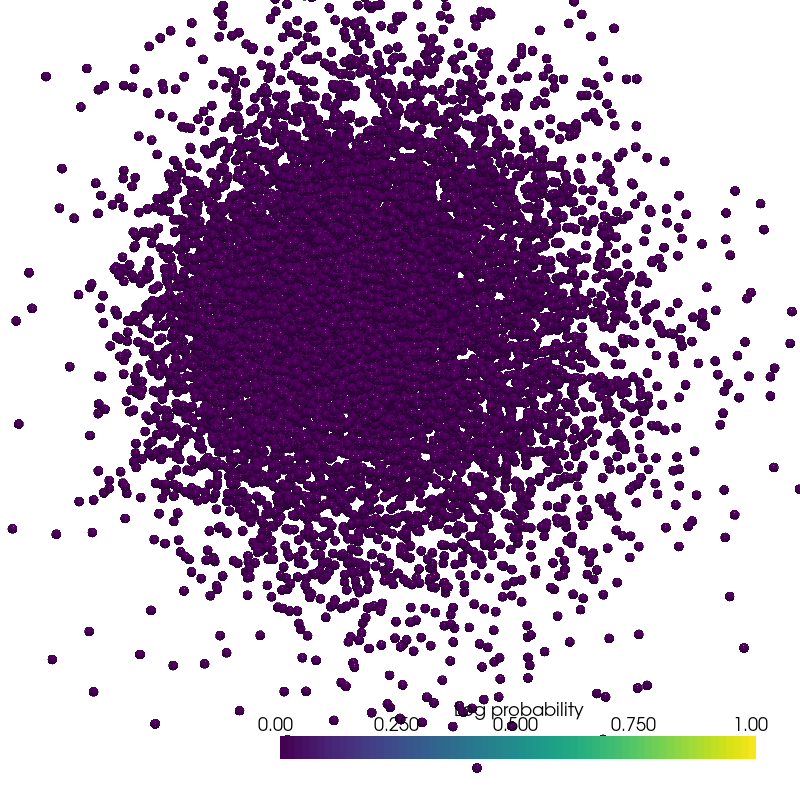

In [24]:
generated_samples = model.sample_posterior(100**2, c=0.5, seed=3)
generated_samples_log_likelihood = torch.zeros(generated_samples.shape[0])
plot_generated_samples(dataset.unnormalise_scale(generated_samples).numpy(), generated_samples_log_likelihood.numpy())